In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from xgboost.sklearn import XGBClassifier

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [6]:
rcParams['figure.figsize'] = 12,4

In [7]:
train_df = pd.read_csv('train.csv', parse_dates=['Dates'])
test_df = pd.read_csv('test.csv', parse_dates=['Dates'])

In [8]:
print(train_df.shape)
print(test_df.shape)
train_df.columns

(878049, 9)
(884262, 7)


Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [9]:
# Convert crime labels to numbers
label_crime = preprocessing.LabelEncoder()
crime = label_crime.fit_transform(train_df.Category)
np.info(crime)

class:  ndarray
shape:  (878049,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x11c76e000
byteorder:  little
byteswap:  False
type: int64


In [10]:
def convert_to_vector(pandas_object):
    days = pd.get_dummies(pandas_object.DayOfWeek)
    district = pd.get_dummies(pandas_object.PdDistrict)
    hour = pandas_object.Dates.dt.hour
    hour = pd.get_dummies(hour)
    
    pandas_data = pd.concat([hour, days, district], axis=1)
    return pandas_data

In [11]:
train_data = convert_to_vector(train_df)
train_data['crime'] = crime
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 42 columns):
0             878049 non-null float64
1             878049 non-null float64
2             878049 non-null float64
3             878049 non-null float64
4             878049 non-null float64
5             878049 non-null float64
6             878049 non-null float64
7             878049 non-null float64
8             878049 non-null float64
9             878049 non-null float64
10            878049 non-null float64
11            878049 non-null float64
12            878049 non-null float64
13            878049 non-null float64
14            878049 non-null float64
15            878049 non-null float64
16            878049 non-null float64
17            878049 non-null float64
18            878049 non-null float64
19            878049 non-null float64
20            878049 non-null float64
21            878049 non-null float64
22            878049 non-null float64
23            8

In [12]:
# do same process for test data
test_data = convert_to_vector(test_df)
test_data.shape

(884262, 41)

In [25]:
target = 'crime'

In [60]:
# def modelfit(alg, train, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
# #         xgtrain = xgb.DMatrix(train[predictors].values, label=train[target].values)
#         xgtrain = xgb.DMatrix(train[predictors], label=train[target])
#         cv_result = xgb.cv(xgb_param, xgtrain, 
#                            num_boost_round=alg.get_params()['n_estimators'], 
#                            nfold=cv_folds,
#                           metrics='auc',
#                           early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cv_result.shape[0])
    
#     # Fit the algorithm on the data
#     alg.fit(dtrain[predictors], dtrain['crime'], eval_metric='auc')
    
#     dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]
    
#     # Print model report
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['crime'].values, dtrain_predictions))
#     print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['crime'], dtrain_predprob))

In [53]:
predictors = [x for x in train_data.columns if x not in ['crime']]

In [54]:
predictors

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 'Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'BAYVIEW',
 'CENTRAL',
 'INGLESIDE',
 'MISSION',
 'NORTHERN',
 'PARK',
 'RICHMOND',
 'SOUTHERN',
 'TARAVAL',
 'TENDERLOIN']

In [58]:
# xgb1 = XGBClassifier(learning_rate=0.1,
#                     n_estimators=10,
#                     max_depth=5,
#                     min_child_weight=1,
#                     gamma=0,
#                     subsample=0.8,
#                     colsample_bytree=0.8,
#                     objective='multi:softprob',
#                     nthread=4,
#                     scale_pos_weight=1,
#                     num_class=39,
#                     seed=27)

TypeError: __init__() got an unexpected keyword argument 'num_class'

In [66]:
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=10,
                      max_depth=5,
                      min_child_weight=1,
                      gamma=0,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      objective='multi:softprob',
                      nthread=4,
                      scale_pos_weight=1,
                      seed=27)

In [69]:
from sklearn.cross_validation import cross_val_score

X_train, y_train = train_data[predictors], train_data["crime"]

score = cross_val_score(model, X_train, y_train, cv=5).mean()

print("score = {0:.6f}".format(score))

score = 0.223318


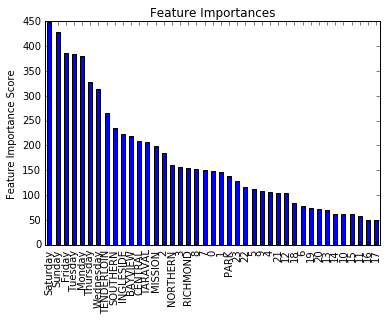

In [71]:
%matplotlib inline
from matplotlib import pyplot as plt

model.fit(X_train, y_train)

feature_importance = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)

feature_importance.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')